In [11]:
import csv
from urllib.request import urlopen
from bs4 import BeautifulSoup as soup


filename = 'weather.csv'
with open(filename, 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)

    
    html = urlopen('https://tianqi.2345.com/')
    bsobj = soup(html.read(), 'html.parser')


    try:
        tbody = bsobj.find('div', {'class': "banner-right-con-list clearfix"}).findAll('div', recursive=False)
    except AttributeError as e:
        print("查找元素时发生错误：", e)
        tbody = []

    
    for row in tbody:
        cols = row.findChildren(recursive=False)
        cols = [element.text.strip() for element in cols]
        if any(cols):  
            writer.writerow(cols)
            print(cols)


['昨天', '07/02', '', '阴', '26~32°']
['今天', '07/03', '', '阴', '26~32°']
['明天', '07/04', '', '多云', '26~30°']
['周五', '07/05', '', '晴', '26~31°']
['周六', '07/06', '', '多云', '26~30°']
['周日', '07/07', '', '晴', '25~31°']
['周一', '07/08', '', '小雨', '25~30°']
['周二', '07/09', '', '中雨', '26~30°']


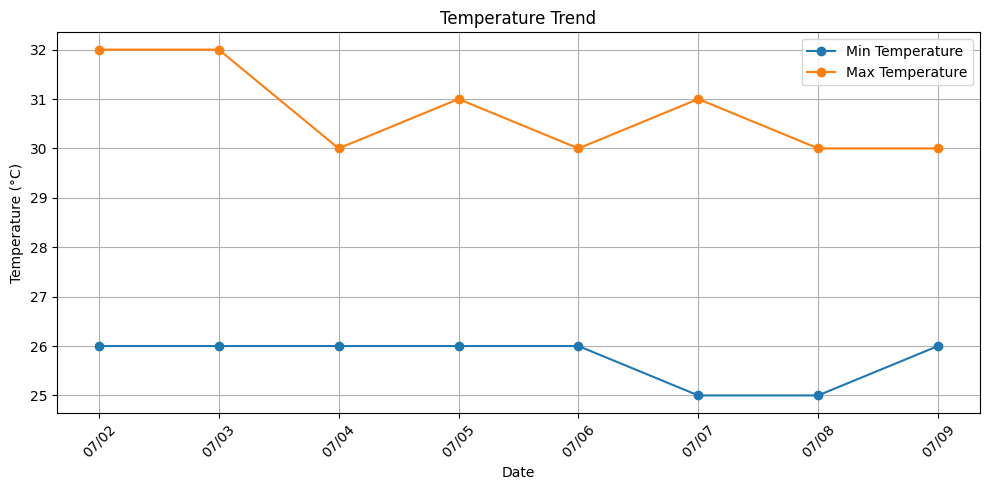

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

filename = 'weather.csv'
df = pd.read_csv(filename, header=None, names=['Day', 'Date', 'Unused', 'Weather', 'Temperature'])


dates = df['Date']
temperatures = df['Temperature']


min_temps = []
max_temps = []

for temp in temperatures:
    temp_range = temp.split('~')
    min_temps.append(int(temp_range[0].replace('°', '')))
    max_temps.append(int(temp_range[1].replace('°', '')))


temp_df = pd.DataFrame({
    'Date': dates,
    'Min Temperature': min_temps,
    'Max Temperature': max_temps
})


plt.figure(figsize=(10, 5))
plt.plot(temp_df['Date'], temp_df['Min Temperature'], marker='o', label='Min Temperature')
plt.plot(temp_df['Date'], temp_df['Max Temperature'], marker='o', label='Max Temperature')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Trend')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()



# 保存图表为PDF文件
pdf_filename = 'temperature_trend.pdf'
plt.savefig(pdf_filename)

# 显示图表
plt.show()


In [13]:
from flask import Flask, render_template
from flask_sqlalchemy import SQLAlchemy
import csv

app = Flask(__name__)

app.config['SQLALCHEMY_DATABASE_URI'] = 'mssql+pyodbc:///?' \
    'driver=ODBC+Driver+17+for+SQL Server&' \
    'trusted_connection=yes&' \
    'server=DESKTOP-D796N6P&' \
    'database=testdb1'

db = SQLAlchemy(app)

class Sid(db.Model):
    __tablename__ = 'sid'
    id = db.Column(db.Integer, primary_key=True)
    date = db.Column(db.String(50))
    weather = db.Column(db.String(200))
    temperature = db.Column(db.String(100))

    def __init__(self, date, weather, temperature):
        self.date = date
        self.weather = weather
        self.temperature = temperature

@app.route('/')
def index():
    with app.app_context():
        db.create_all()
    return "數據庫連接成功！"

@app.route('/insertall')
def insertall():
    filename = 'weather.csv'
    datas = []

    with open(filename, 'r', encoding='utf-8') as file:
        csv_reader = csv.reader(file)
        for row in csv_reader:
            if row:
                date = row[1]
                weather = row[3]
                temperature = row[4]
                datas.append(Sid(date, weather, temperature))

    db.session.add_all(datas)
    db.session.commit()
    return "數據批量插入成功！"

@app.route('/queryall')
def queryall():
    datas = Sid.query.all()
    return render_template('index.html', data=datas)

if __name__ == '__main__':
    app.run(host='192.168.168.10', port=5000, debug=False)


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://192.168.168.10:5000
Press CTRL+C to quit
192.168.168.10 - - [03/Jul/2024 23:02:03] "GET / HTTP/1.1" 200 -
192.168.168.10 - - [03/Jul/2024 23:02:03] "GET /favicon.ico HTTP/1.1" 404 -
192.168.168.10 - - [03/Jul/2024 23:02:18] "GET /insertall HTTP/1.1" 200 -
192.168.168.10 - - [03/Jul/2024 23:02:32] "GET /queryall HTTP/1.1" 200 -
192.168.168.10 - - [03/Jul/2024 23:02:32] "GET /static/temperature_trend.pdf HTTP/1.1" 304 -
